# Problem Description

2D linear elasticity example

Solve the equilibrium equation:
\begin{equation}
-\nabla \cdot \sigma(x) = f(x) \quad \text{for } x \in \Omega 
\end{equation}

with the strain-displacement equation:
\begin{equation}
\epsilon = \frac{1}{2}(\nabla u + \nabla u^T)
\end{equation}

and the constitutive law:
\begin{equation}
\sigma = 2 \mu \epsilon + \lambda (\nabla \cdot u) I
\end{equation}

where \(\mu\) and \(\lambda\) are Lamé constants, and \(I\) is the identity tensor.

Dirichlet boundary conditions:
\begin{equation}
u(x) = \hat{u} \quad \text{for } x \in \Gamma_D
\end{equation}

Neumann boundary conditions:
\begin{equation}
\sigma n = \hat{t} \quad \text{for } x \in \Gamma_N
\end{equation}

where \(n\) is the normal vector.

For this example:
\(\Omega\) is a plate of side 4 in the second quadrant with a hole of radius 1 centered at the origin.

Symmetry (Dirichlet) boundary conditions on the x and y axes:
\begin{equation}
u_x(x,y) = 0 \quad \text{for } x=0
\end{equation}
\begin{equation}
u_y(x,y) = 0 \quad \text{for } y=0
\end{equation}

and pressure boundary conditions for the curved boundaries:
\begin{equation}
\sigma n = P_\text{int} n \quad \text{on the interior boundary with } P_\text{int} = 10 \text{ MPa}
\end{equation}
\begin{equation}
\sigma n = P_\text{ext} n \quad \text{on the exterior boundary with } P_\text{ext} = 0 \text{ MPa}
\end{equation}

Deep Energy Method



Import Libraries and Utilities

In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from utils.tfp_loss import tfp_function_factory
from utils.Geom_examples import PlateWHole
from utils.Solvers import Elasticity2D_DEM_dist
from utils.Plotting import plot_field_2d, plot_convergence_dem

np.random.seed(42)
tf.random.set_seed(42)

### Define the Elasticity Model with Symmetry Boundary Conditions
We define a custom class `Elast_PlateWithHole` that extends `Elasticity2D_DEM_dist` to include symmetry boundary conditions for our plate with a hole problem.


In [5]:
class Elast_PlateWithHole(Elasticity2D_DEM_dist):
    '''Class including the symmetry boundary conditions for the plate with hole problem'''       
    def __init__(self, layers, train_op, num_epoch, print_epoch, model_data, data_type):        
        super().__init__(layers, train_op, num_epoch, print_epoch, model_data, data_type)
       
    @tf.function
    def dirichletBound(self, X, xPhys, yPhys):    
        # multiply by x, y for strong imposition of boundary conditions
        u_val = X[:,0:1]
        v_val = X[:,1:2]
        
        u_val = xPhys*u_val
        v_val = yPhys*v_val
        
        return u_val, v_val


### Define Helper Functions
We define several helper functions to convert between Cartesian and polar coordinates, calculate exact stresses, and compute exact tractions.


In [9]:
def cart2pol(x, y):
    rho = np.sqrt(np.array(x)**2 + np.array(y)**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
    
def exact_stresses(x,y,model):
    numPts = len(x)
    sigma_xx = np.zeros_like(x)
    sigma_yy = np.zeros_like(x)
    sigma_xy = np.zeros_like(x)
    x = np.squeeze(x)
    y = np.squeeze(y)
    for i in range(numPts):
        r, th = cart2pol(x[i],y[i])
    
        R = model['radInt']
        tx = model['P']
        
        stressrr = tx/2*(1-R**2/r**2)+tx/2*(1-4*R**2/r**2+3*R**4/r**4)*np.cos(2*th)
        stresstt = tx/2*(1+R**2/r**2)-tx/2*(1+3*R**4/r**4)*np.cos(2*th)
        stressrt = -tx/2*(1+2*R**2/r**2-3*R**4/r**4)*np.sin(2*th)
        
        A = np.array([[np.cos(th)**2, np.sin(th)**2, 2*np.sin(th)*np.cos(th)],
                       [np.sin(th)**2, np.cos(th)**2, -2*np.sin(th)*np.cos(th)],
                       [-np.sin(th)*np.cos(th), np.sin(th)*np.cos(th), 
                        np.cos(th)**2-np.sin(th)**2]])
                
        stress = np.linalg.solve(A,np.array([stressrr,stresstt,stressrt]))
        sigma_xx[i] = stress[0]
        sigma_yy[i] = stress[1]
        sigma_xy[i] = stress[2]
                             
    return sigma_xx, sigma_yy, sigma_xy

def getExactTraction(x, y, xNorm, yNorm, model):    
    sigma_xx, sigma_yy, sigma_xy = exact_stresses(x[:,0], y[:,0], model)
    sigma_xx = np.expand_dims(sigma_xx, axis=1)
    sigma_yy = np.expand_dims(sigma_yy, axis=1)
    sigma_xy = np.expand_dims(sigma_xy, axis=1)
    trac_x = xNorm[:,0:1]*sigma_xx + yNorm[:,0:1]*sigma_xy
    trac_y = xNorm[:,0:1]*sigma_xy + yNorm[:,0:1]*sigma_yy
    
    return trac_x, trac_y

### Set Up the Model and Train
We set up the model by defining the domain, boundary conditions, and initializing the neural network layers. Then, we train the model using the Adam optimizer followed by BFGS for fine-tuning.


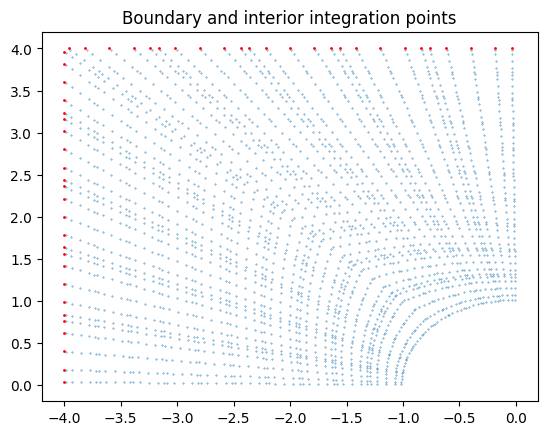

Training (ADAM)...
Epoch 0 loss: 27.21474027073384, loss_int: 19.25090073718632, loss_bnd: -7.963839533547521
Epoch 100 loss: -7.790871725249773, loss_int: 7.92358665740952, loss_bnd: 15.714458382659293
Epoch 200 loss: -7.857909243036696, loss_int: 7.858206547833623, loss_bnd: 15.716115790870319
Epoch 300 loss: -7.877693905261502, loss_int: 7.888333865078341, loss_bnd: 15.766027770339843
Epoch 400 loss: -7.893170100768911, loss_int: 7.899619238543739, loss_bnd: 15.79278933931265
Epoch 500 loss: -7.9108859742914905, loss_int: 7.906459021495502, loss_bnd: 15.817344995786993
Epoch 600 loss: -7.932616645415246, loss_int: 7.914722154440135, loss_bnd: 15.84733879985538
Epoch 700 loss: -7.960262922406381, loss_int: 7.926953945016228, loss_bnd: 15.887216867422609
Epoch 800 loss: -7.994371144219877, loss_int: 7.947354019715042, loss_bnd: 15.941725163934919
Epoch 900 loss: -8.029321338106783, loss_int: 7.980611356601263, loss_bnd: 16.009932694708045
Epoch 1000 loss: -8.05522878756493, loss_int: 

In [10]:
model_data = dict()
model_data['E'] = 1e2
model_data['nu'] = 0.3
model_data['state'] = "plane stress"

model_data['radInt'] = 1.0
model_data['lenSquare'] = 4.0
model_data['P'] = 10.0

# Generating points inside the domain using Geometry class
geomDomain = PlateWHole(model_data['radInt'], model_data['lenSquare'])

numElemU = 10
numElemV = 10
numGauss = 5
xPhys, yPhys, Wint = geomDomain.getQuadIntPts(numElemU, numElemV, numGauss)
data_type = "float64"

Xint = np.concatenate((xPhys,yPhys),axis=1).astype(data_type)
Wint = np.array(Wint).astype(data_type)

#geomDomain.plotKntSurf()

# prepare boundary points in the fromat Xbnd = [Xcoord, Ycoord, norm_x, norm_y] and
# Wbnd for boundary integration weights and
# Ybnd = [trac_x, trac_y], where Xcoord, Ycoord are the x and y coordinates of the point,
# norm_x, norm_y are the x and y components of the unit normals
# trac_x, trac_y are the x and y components of the traction vector at each point


# boundary along x=-4 and y=4 include both x and y directions
xPhysBnd, yPhysBnd, xNorm, yNorm, Wbnd = geomDomain.getQuadEdgePts(numElemU, numGauss, 3)
Xbnd = np.concatenate((xPhysBnd, yPhysBnd), axis=1).astype(data_type)

plt.scatter(xPhys, yPhys, s=0.1)
plt.scatter(xPhysBnd, yPhysBnd, s=1, c='red')
plt.title("Boundary and interior integration points")
plt.show()

#define loading
# exact traction on the boundary along x=-4 and y=4
Ybnd_x, Ybnd_y = getExactTraction(xPhysBnd, yPhysBnd, xNorm, yNorm, model_data)
Wbnd = np.array(Wbnd).astype(data_type)
Ybnd = np.concatenate((Ybnd_x, Ybnd_y), axis=1).astype(data_type)

    
#define the model 
tf.keras.backend.set_floatx(data_type)
l1 = tf.keras.layers.Dense(20, "swish")
l2 = tf.keras.layers.Dense(20, "swish")
l3 = tf.keras.layers.Dense(20, "swish")
l4 = tf.keras.layers.Dense(2, None)
train_op = tf.keras.optimizers.Adam()
train_op2 = "TFP-BFGS"
num_epoch = 10000
print_epoch = 100
pred_model = Elast_PlateWithHole([l1, l2, l3, l4], train_op, num_epoch, 
                                    print_epoch, model_data, data_type)

#convert the training data to tensors
Xint_tf = tf.convert_to_tensor(Xint)
Wint_tf = tf.convert_to_tensor(Wint)
Xbnd_tf = tf.convert_to_tensor(Xbnd)
Wbnd_tf = tf.convert_to_tensor(Wbnd)
Ybnd_tf = tf.convert_to_tensor(Ybnd)

#training
t0 = time.time()
print("Training (ADAM)...")

pred_model.network_learn(Xint_tf, Wint_tf, Xbnd_tf, Wbnd_tf, Ybnd_tf)
t1 = time.time()
print("Time taken (ADAM)", t1-t0, "seconds")
print("Training (TFP-BFGS)...")

loss_func = tfp_function_factory(pred_model, Xint_tf, Wint_tf, Xbnd_tf, Wbnd_tf, Ybnd_tf)
# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables)
# train the model with BFGS solver
results = tfp.optimizer.bfgs_minimize(
    value_and_gradients_function=loss_func, initial_position=init_params,
          max_iterations=1000, tolerance=1e-14)  
# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
loss_func.assign_new_model_parameters(results.position)    
t2 = time.time()
print("Time taken (BFGS)", t2-t1, "seconds")
print("Time taken (all)", t2-t0, "seconds")

#define the exact displacements
def exact_disp(x,y,model):
    r, th = cart2pol(x,y)

    E = model['E']
    nu = model['nu']
    R = model['radInt']
    tx = model['P']
    
    u_exact = (1+nu)/E*tx*(1/(1+nu)*r*np.cos(th)+2*R**2/((1+nu)*r)*np.cos(th)+ \
        R**2/(2*r)*np.cos(3*th)-R**4/(2*r**3)*np.cos(3*th))
    v_exact = (1+nu)/E*tx*(-nu/(1+nu)*r*np.sin(th)-(1-nu)*R**2/((1+nu)*r)*np.sin(th)+ \
        R**2/(2*r)*np.sin(3*th)-R**4/(2*r**3)*np.sin(3*th))
                             
    return u_exact, v_exact


### Testing the Model and Plotting Results
After training, we test the model by comparing its predictions with exact solutions and plot the resulting fields and errors.


Testing...


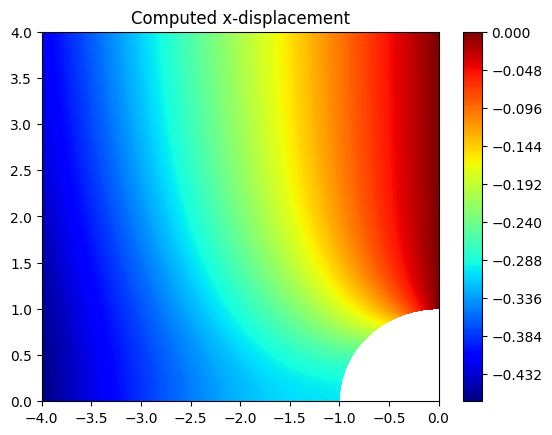

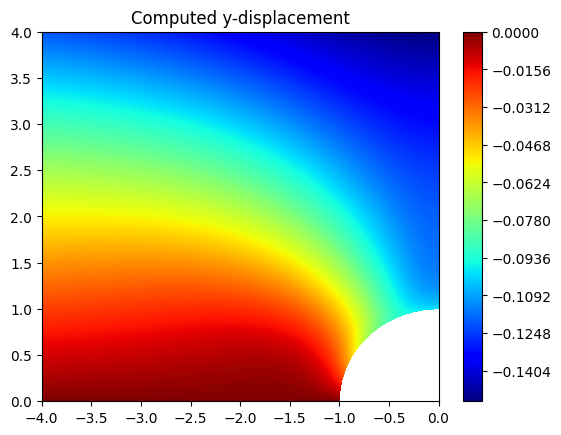

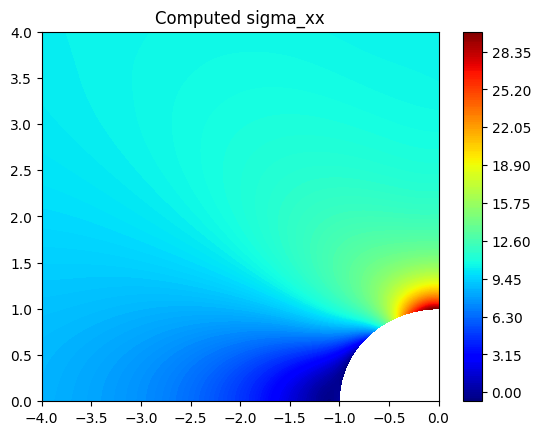

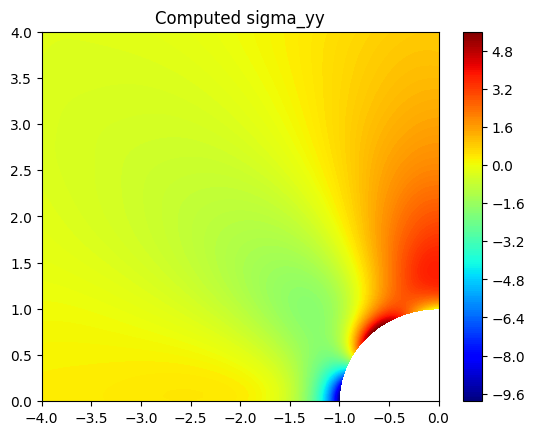

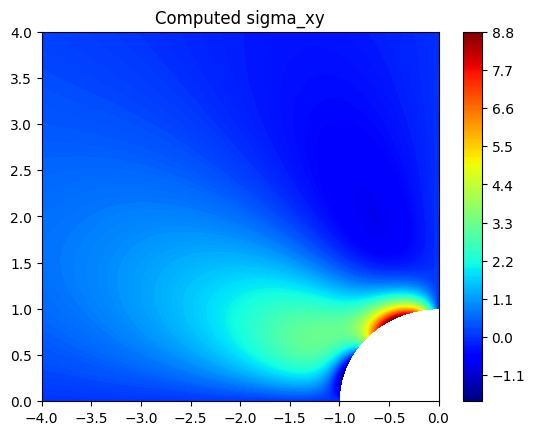

In [13]:
def exact_disp(x,y,model):
    r, th = cart2pol(x,y)

    E = model['E']
    nu = model['nu']
    R = model['radInt']
    tx = model['P']
    
    u_exact = (1+nu)/E*tx*(1/(1+nu)*r*np.cos(th)+2*R**2/((1+nu)*r)*np.cos(th)+ \
        R**2/(2*r)*np.cos(3*th)-R**4/(2*r**3)*np.cos(3*th))
    v_exact = (1+nu)/E*tx*(-nu/(1+nu)*r*np.sin(th)-(1-nu)*R**2/((1+nu)*r)*np.sin(th)+ \
        R**2/(2*r)*np.sin(3*th)-R**4/(2*r**3)*np.sin(3*th))
                             
    return u_exact, v_exact

print("Testing...")
numPtsUTest = 2*numElemU*numGauss
numPtsVTest = 2*numElemV*numGauss
xPhysTest, yPhysTest = geomDomain.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1])
XTest = np.concatenate((xPhysTest,yPhysTest),axis=1).astype(data_type)
XTest_tf = tf.convert_to_tensor(XTest)
YTest = pred_model(XTest_tf).numpy()
xPhysTest = xPhysTest.astype(data_type)
yPhysTest = yPhysTest.astype(data_type)
stress_xx_comp, stress_yy_comp, stress_xy_comp = pred_model.constitutiveEq(xPhysTest, yPhysTest)
stress_xx_comp = stress_xx_comp.numpy()
stress_yy_comp = stress_yy_comp.numpy()
stress_xy_comp = stress_xy_comp.numpy() 

# plot the displacement
plot_field_2d(XTest, YTest[:,0], numPtsUTest, numPtsVTest, title="Computed x-displacement")
plot_field_2d(XTest, YTest[:,1], numPtsUTest, numPtsVTest, title="Computed y-displacement")

# plot the stresses
plot_field_2d(XTest, stress_xx_comp, numPtsUTest, numPtsVTest, title="Computed sigma_xx")
plot_field_2d(XTest, stress_yy_comp, numPtsUTest, numPtsVTest, title="Computed sigma_yy")
plot_field_2d(XTest, stress_xy_comp, numPtsUTest, numPtsVTest, title="Computed sigma_xy")

### Error Analysis and Conclusion
Finally, we calculate the relative L2 error and energy error to evaluate the performance of the model.


Relative L2 error:  6.382664732525095e-05
Relative energy error:  0.002371715595474534


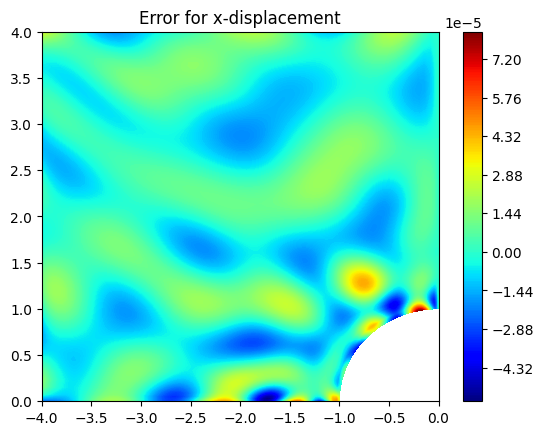

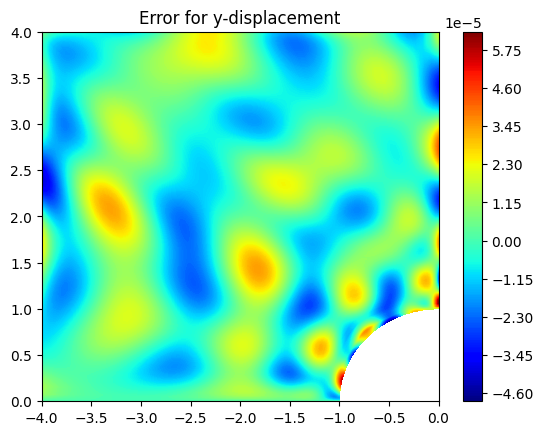

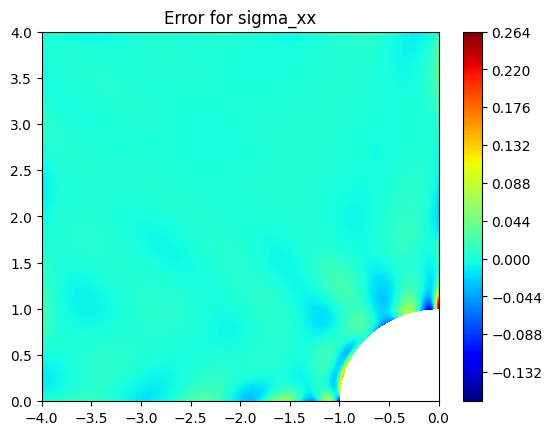

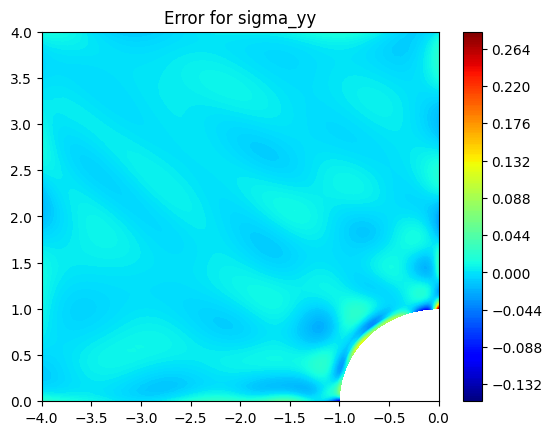

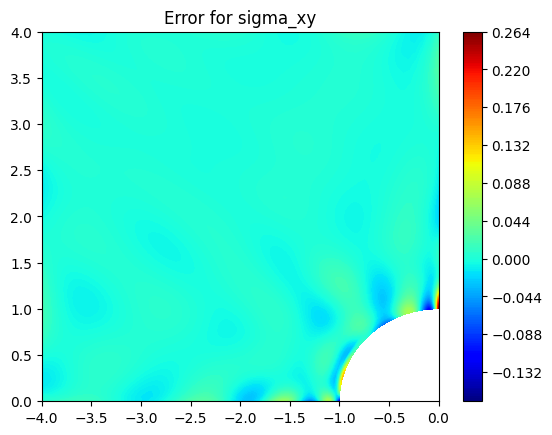

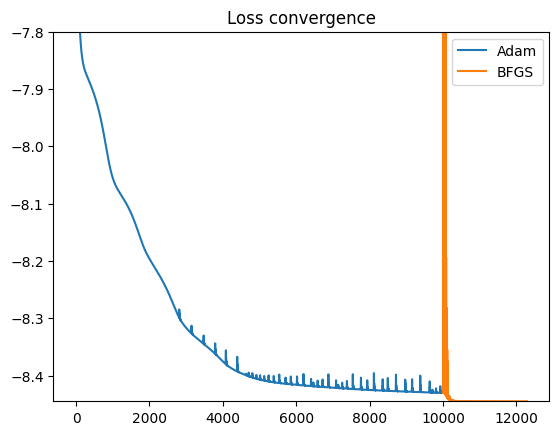

In [14]:
# comparison with exact solution    
ux_exact, uy_exact = exact_disp(xPhysTest, yPhysTest, model_data)
ux_test = YTest[:,0:1]    
uy_test = YTest[:,1:2]
err_norm = np.sqrt(np.sum((ux_exact-ux_test)**2+(uy_exact-uy_test)**2))
ex_norm = np.sqrt(np.sum(ux_exact**2 + uy_exact**2))
rel_err_l2 = err_norm/ex_norm
print("Relative L2 error: ", rel_err_l2)

stress_xx_exact, stress_yy_exact, stress_xy_exact = exact_stresses(xPhysTest,  
                                                        yPhysTest, model_data)

stress_xx_err = stress_xx_exact - stress_xx_comp
stress_yy_err = stress_yy_exact - stress_yy_comp
stress_xy_err = stress_xx_exact - stress_xx_comp

C_inv = np.linalg.inv(pred_model.Emat.numpy())
energy_err = 0.
energy_norm = 0.
numPts = len(xPhysTest)
for i in range(numPts):
    err_pt = np.array([stress_xx_err[i,0],stress_yy_err[i,0],stress_xy_err[i,0]])
    norm_pt = np.array([stress_xx_exact[i,0],stress_yy_exact[i,0],stress_xy_exact[i,0]])
    energy_err = energy_err + err_pt@C_inv@err_pt.T
    energy_norm = energy_norm + norm_pt@C_inv@norm_pt.T

print("Relative energy error: ", np.sqrt(energy_err/energy_norm))


plot_field_2d(XTest, ux_exact-YTest[:,0:1], numPtsUTest, numPtsVTest, title="Error for x-displacement")
plot_field_2d(XTest, uy_exact-YTest[:,1:2], numPtsUTest, numPtsVTest, title="Error for y-displacement")



plot_field_2d(XTest, stress_xx_err, numPtsUTest, numPtsVTest, title="Error for sigma_xx")
plot_field_2d(XTest, stress_yy_err, numPtsUTest, numPtsVTest, title="Error for sigma_yy")
plot_field_2d(XTest, stress_xy_err, numPtsUTest, numPtsVTest, title="Error for sigma_xy")

# plot the loss convergence
plot_convergence_dem(pred_model.adam_loss_hist, loss_func.history)